In [1]:
!pip install --upgrade pip

    100% |████████████████████████████████| 1.4MB 100.3MB/s a 0:00:011
  Found existing installation: pip 9.0.1
    Uninstalling pip-9.0.1:
      Successfully uninstalled pip-9.0.1


In [2]:
!pip install -r ../requirements.txt

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 20.1MB 30.2MB/s eta 0:00:01                     | 3.5MB 30.2MB/s eta 0:00:01| 7.4MB 30.2MB/s eta 0:00:01          | 12.2MB 30.2MB/s eta 0:00:01████▍       | 15.3MB 30.2MB/s eta 0:00:01
     |████████████████████████████████| 2.1MB 74.9MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 24.5MB/s eta 0:00:01
     |████████████████████████████████| 61kB 71.1MB/s eta 0:00:01
  Found existing installation: numpy 1.14.0
    Uninstalling numpy-1.14.0:
      Successfully uninstalled numpy-1.14.0
  Found existing installation: Pillow 5.0.0
    Uninstalling Pillow-5.0.0:
      Successfully uninstalled Pillow-5.0.0
  Found existing installation: h5py 2.7.1
    Uninstalling h5py-2.7.1:
      Successfully uninstalled h5py-2.7.1


In [3]:
!pip install torch

Looking in indexes: http://repo.myhuaweicloud.com/repository/pypi/simple
     |████████████████████████████████| 734.6MB 90.7MB/s eta 0:00:01/s eta 0:00:11    | 7.6MB 71.7MB/s eta 0:00:11               | 12.0MB 71.7MB/s eta 0:00:11B/s eta 0:00:11               | 20.4MB 71.7MB/s eta 0:00:10               | 25.4MB 71.7MB/s eta 0:00:10                     | 29.3MB 71.7MB/s eta 0:00:10                     | 33.8MB 71.7MB/s eta 0:00:10                     | 38.4MB 71.7MB/s eta 0:00:10                     | 42.3MB 71.7MB/s eta 0:00:10                     | 47.1MB 71.7MB/s eta 0:00:1010101010100:10                         | 78.4MB 71.7MB/s eta 0:00:10�                            | 82.6MB 63.6MB/s eta 0:00:11                         | 87.8MB 63.6MB/s eta 0:00:11                         | 92.1MB 63.6MB/s eta 0:00:11.1MB 63.6MB/s eta 0:00:11                     | 99.7MB 63.6MB/s eta 0:00:10      | 103.2MB 63.6MB/s eta 0:00:10��██▋                           | 107.1MB 63.6MB/s eta 0:00:10.6MB/s et

In [1]:
import torch
import torch.backends.cudnn as cudnn
import numpy as np
import PIL.Image as pil_image

from models import RDN

import pandas as pd
import os

from utils import convert_rgb_to_y, denormalize, calc_psnr

In [5]:
def test(weights_file, image_file, num_features=64, growth_rate=64, num_blocks=16, num_layers=8, scale=4):
    cudnn.benchmark = True
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

    model = RDN(scale_factor=scale,
                num_channels=3,
                num_features=num_features,
                growth_rate=growth_rate,
                num_blocks=num_blocks,
                num_layers=num_layers).to(device)

    state_dict = model.state_dict()
    for n, p in torch.load(weights_file, map_location=lambda storage, loc: storage).items():
        if n in state_dict.keys():
            state_dict[n].copy_(p)
        else:
            raise KeyError(n)

    model.eval()

    image = pil_image.open(image_file).convert('RGB')

    image_width = (image.width // scale) * scale
    image_height = (image.height // scale) * scale

    hr = image.resize((image_width, image_height), resample=pil_image.BICUBIC)
    lr = hr.resize((hr.width // scale, hr.height // scale), resample=pil_image.BICUBIC)
    bicubic = lr.resize((lr.width * scale, lr.height * scale), resample=pil_image.BICUBIC)
    bicubic.save(image_file.replace('.png', '_bicubic_x{}.png'.format(scale)))

    lr = np.expand_dims(np.array(lr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    hr = np.expand_dims(np.array(hr).astype(np.float32).transpose([2, 0, 1]), 0) / 255.0
    lr = torch.from_numpy(lr).to(device)
    hr = torch.from_numpy(hr).to(device)

    with torch.no_grad():
        preds = model(lr).squeeze(0)

    preds_y = convert_rgb_to_y(denormalize(preds), dim_order='chw')
    hr_y = convert_rgb_to_y(denormalize(hr.squeeze(0)), dim_order='chw')

    preds_y = preds_y[scale:-scale, scale:-scale]
    hr_y = hr_y[scale:-scale, scale:-scale]

    psnr = calc_psnr(hr_y, preds_y)
#     print('PSNR: {:.2f}'.format(psnr))

    output = pil_image.fromarray(denormalize(preds).permute(1, 2, 0).byte().cpu().numpy())
    output.save(image_file.replace('.png', '_rdn_x{}.png'.format(scale)))
    
    return {
        "test_set" : image_file.split("/")[1],
        "psnr" : psnr.item()
    }

In [6]:
models_dir = "../rdn-results/outputs/x4/"
images_dir = ["../BSDS100/", "../Set5/", "../Set14/", "../Urban100/"]

In [7]:
test_images = {}
for test_dir in images_dir:
    f = []
    for (dirpath, dirnames, filenames) in os.walk(test_dir):
        f.extend(filenames)
        break
    test_images[test_dir.split("/")[1]] = f

In [8]:
five_up = {}
for i in test_images.keys():
    five_up[i] = test_images[i][:5]

In [9]:
pd.DataFrame(five_up)

,BSDS100,Set14,Set5,Urban100
0,306005_bicubic_x4.png,barbara.png,bird_bicubic_x4.png,img_006.png
1,229036.png,comic.png,head_bicubic_x4.png,img_012_rdn_x4.png
2,43074_bicubic_x4.png,flowers_rdn_x4.png,bird.png,img_070_bicubic_x4.png
3,24077.png,zebra_bicubic_x4.png,baby_bicubic_x4.png,img_031_rdn_x4.png
4,38092_rdn_x4.png,foreman.png,woman_bicubic_x4.png,img_078.png


In [10]:
### get best model 
log_name = "base-sdg.log"
train_log = open("../rdn-results/logs/" + log_name)
k = 0
train_log_arr = []
for i in train_log.read().split("\n"):
    if i:
        train_log_arr.append((k, float(i.split(":")[1])))
        k+=1

train_log_arr_sorted = sorted(train_log_arr, reverse=True, key=lambda x: x[1])

In [11]:
best_epoch = train_log_arr_sorted[0][0]
best_epoch

296

In [12]:
# display learning chart 

In [13]:
def create_dict_from_train_log(arr):
   
    return {"eval psnr": float(arr[1])}
    

In [14]:
def process_train_loss_line(line):
    loss_arr = line.split("[")[-1].split(", ")[-1].replace("]", "").split("=")
    epoch = line.split(":")[1].split("/")[0]
    
    return {"epoch" : epoch, loss_arr[0] : float(loss_arr[1])}
    
    

### parse the training log copied from std output during training 

In [15]:
train_log_loss = open("../rdn-results/logs/train-loss.log")
train_log_loss_arr = [process_train_loss_line(i) for i in train_log_loss.read().split("\n") if "epoch" in i]
df_train_loss = pd.DataFrame(train_log_loss_arr)
df_train_loss.head()

,epoch,loss
0,0,0.416275
1,1,0.402584
2,2,0.390440
3,3,0.373659
4,4,0.356863


In [16]:
df_train_loss["loss"].plot(figsize=(15, 5))

In [17]:
train_log_dicts = [ create_dict_from_train_log(i) for i in train_log_arr[:-1]]

In [18]:
train_df = pd.DataFrame(train_log_dicts)
train_df.head()

,eval psnr
0,9.02
1,9.27
2,9.55
3,9.87
4,10.23


### progression of psnr across epochs

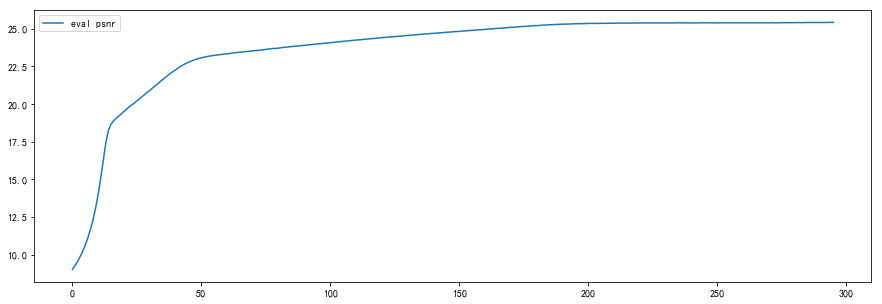

In [19]:
train_df.plot(figsize=(15, 5))

In [20]:
weights_file = models_dir + "best.pth"

if not os.path.isfile(weights_file):
    weights_file = models_dir + "epoch_{}.pth".format(best_epoch - best_epoch%10 - 1)

os.path.isfile(weights_file), weights_file

(True, '../rdn-results/outputs/x4/epoch_289.pth')

In [21]:
test_results = []
if os.path.isfile(weights_file):
    for key in test_images.keys():
        max_images = 0
        print ("testing " + key)
        for image in test_images[key]:
            if not ("_rdn_x4" in image or "_bicubic_x" in image):
                image_file = "../" + key + "/" + image
                test_results.append(test(weights_file, image_file))
                max_images += 1
            

testing BSDS100
testing Set5
testing Set14
testing Urban100


In [2]:
def get_test_report(array_of_dicts, dataset):
    this_arr = [i for i in array_of_dicts if dataset == i["test_set"] ]
    return pd.DataFrame(this_arr)

In [9]:
import json 

with open("../rdn-results/logs/test-results.json", mode='r', encoding='utf-8') as f:
    test_results = json.load(f)
    
test_results


[{'psnr': 20.542659759521484, 'test_set': 'BSDS100'},
 {'psnr': 21.180112838745117, 'test_set': 'BSDS100'},
 {'psnr': 19.256229400634766, 'test_set': 'BSDS100'},
 {'psnr': 21.391143798828125, 'test_set': 'BSDS100'},
 {'psnr': 24.380939483642578, 'test_set': 'BSDS100'},
 {'psnr': 26.94746208190918, 'test_set': 'BSDS100'},
 {'psnr': 24.2758731842041, 'test_set': 'BSDS100'},
 {'psnr': 26.09122085571289, 'test_set': 'BSDS100'},
 {'psnr': 23.731393814086914, 'test_set': 'BSDS100'},
 {'psnr': 22.071535110473633, 'test_set': 'BSDS100'},
 {'psnr': 31.66015625, 'test_set': 'BSDS100'},
 {'psnr': 18.940027236938477, 'test_set': 'BSDS100'},
 {'psnr': 25.909713745117188, 'test_set': 'BSDS100'},
 {'psnr': 27.858741760253906, 'test_set': 'BSDS100'},
 {'psnr': 25.20849609375, 'test_set': 'BSDS100'},
 {'psnr': 20.568864822387695, 'test_set': 'BSDS100'},
 {'psnr': 22.26462173461914, 'test_set': 'BSDS100'},
 {'psnr': 22.996976852416992, 'test_set': 'BSDS100'},
 {'psnr': 20.251209259033203, 'test_set': 'B

In [10]:
stats_BSDS100 = get_test_report(test_results, "BSDS100")

In [12]:
stats_BSDS100.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
psnr,100.0,24.409727,2.856627,18.940027,22.422641,23.93301,26.364944,32.529213


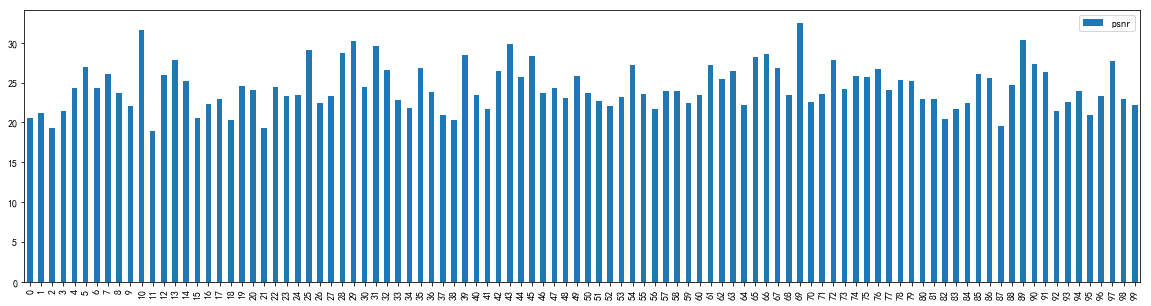

In [26]:
stats_BSDS100.plot.bar(figsize=(20,5))

In [13]:
stats_Set5 = get_test_report(test_results, "Set5")
stats_Set5.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
psnr,5.0,24.221678,3.758802,18.610556,23.23394,23.973595,27.119703,28.170595


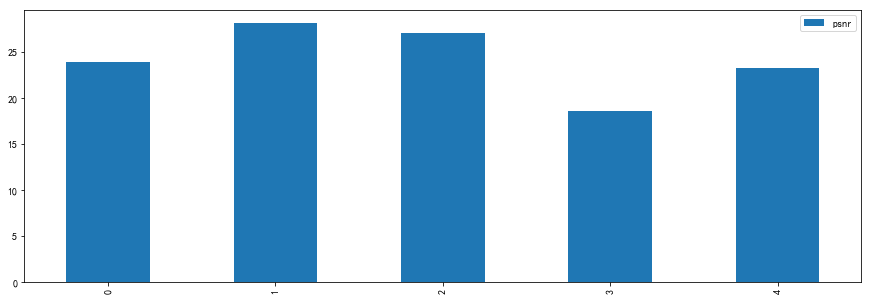

In [28]:
stats_Set5.plot.bar(figsize = (15,5))

In [14]:
stats_Set14 = get_test_report(test_results, "Set14")
stats_Set14.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
psnr,14.0,23.065191,2.209546,20.023106,21.34559,23.326127,24.053425,27.125595


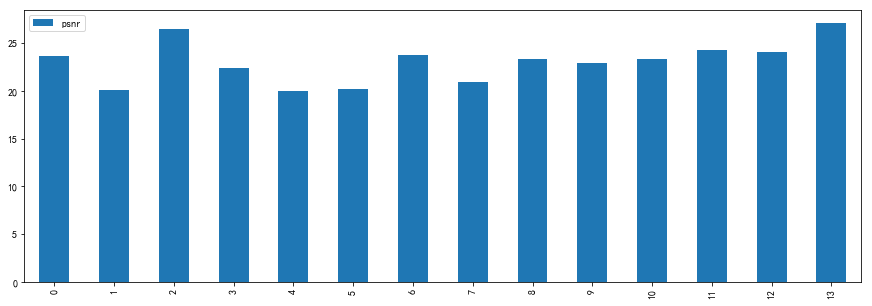

In [30]:
stats_Set14.plot.bar(figsize = (15,5))

In [15]:
stats_Urban100 = get_test_report(test_results, "Urban100")
stats_Urban100.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
psnr,100.0,21.339936,2.869717,14.583412,19.31443,21.280582,23.115455,30.343632


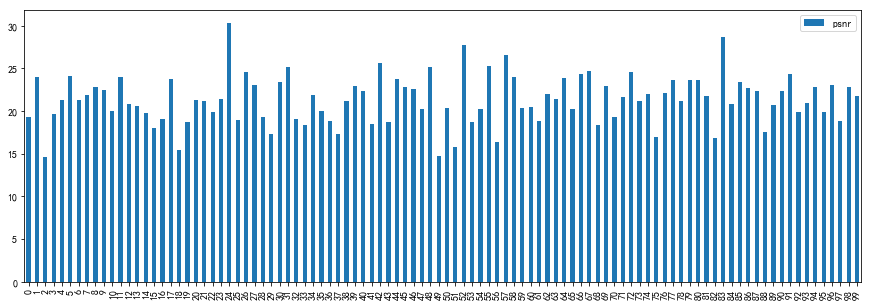

In [32]:
stats_Urban100.plot.bar(figsize = (15,5))